In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

In [2]:
def default_loader(path):
    return Image.open(path).convert('RGB')

class RetinalDiseaseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.loader = default_loader
        self.classes = ['diabetic_retinopathy', 'normal', 'cataract', 'glaucoma']

    def __getitem__(self, index):
        img_path, target = self.samples[index]
        img = self.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.samples)

    def prepare_samples(self):
        self.samples = []
        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_dir, class_name)
            imgs = os.listdir(class_path)
            self.samples.extend([(os.path.join(class_path, img), i) for img in imgs])

        np.random.shuffle(self.samples)

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(42)

# Define transforms for the dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_dir = '/kaggle/input/multiclassification/train-20231109T183113Z-001/train'
val_data_dir = '/kaggle/input/multiclassification/test-20231109T183113Z-001/test'

# Create train and validation datasets
train_dataset = ImageFolder(train_data_dir, transform=train_transform)
val_dataset = ImageFolder(val_data_dir, transform=val_transform)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [4]:

class VisionTransformer(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformer, self).__init__()
        self.vit = timm.create_model('vit_large_patch16_224', pretrained=True)
        self.num_classes = num_classes
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [5]:
class ResNet101(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101, self).__init__()
        self.resnet = timm.create_model('resnet101', pretrained=True)
        self.num_classes = num_classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [6]:
class VotingEnsemble(nn.Module):
    def __init__(self, models):
        super(VotingEnsemble, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        logits = [model(x) for model in self.models]
        avg_logits = torch.mean(torch.stack(logits), dim=0)
        return avg_logits

In [13]:
# Define the models
vision_transformer = VisionTransformer(num_classes=4)
resnet101 = ResNet101(num_classes=4)

# Move models to the device
vision_transformer = vision_transformer.to(device)
resnet101 = resnet101.to(device)

# Define the optimizer and learning rate scheduler
optimizer = optim.Adam(
    [{'params': vision_transformer.parameters(), 'lr': 1e-4},
     {'params': resnet101.parameters(), 'lr': 1e-4}],
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Train the models
num_epochs = 15

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Set models to train mode
    vision_transformer.train()
    resnet101.train()

    train_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients for each batch
        optimizer.zero_grad()

        # Forward pass
        outputs = torch.cat([vision_transformer(images), resnet101(images)], dim=1)
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update training loss
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100.0 * correct / total
    train_loss /= len(train_loader)

    # Set models to evaluation mode
    vision_transformer.eval()
    resnet101.eval()

    correct = 0
    total = 0
    val_loss = 0.0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation dataset
        for images, labels in val_loader:
            # Move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = torch.cat([vision_transformer(images), resnet101(images)], dim=1)
            loss = loss_fn(outputs, labels)

            # Update validation loss
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100.0 * correct / total
    val_loss /= len(val_loader)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Append metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print training and validation accuracy and loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')


Epoch [1/15]: Train Loss: 1.1713, Train Accuracy: 53.20, Val Loss: 0.6336, Val Accuracy: 74.79
Epoch [2/15]: Train Loss: 0.7224, Train Accuracy: 72.54, Val Loss: 0.5347, Val Accuracy: 80.62
Epoch [3/15]: Train Loss: 0.5676, Train Accuracy: 78.85, Val Loss: 0.3641, Val Accuracy: 85.37
Epoch [4/15]: Train Loss: 0.4785, Train Accuracy: 80.86, Val Loss: 0.3863, Val Accuracy: 85.73
Epoch [5/15]: Train Loss: 0.4515, Train Accuracy: 82.94, Val Loss: 0.4274, Val Accuracy: 84.19
Epoch [6/15]: Train Loss: 0.4236, Train Accuracy: 83.74, Val Loss: 0.3296, Val Accuracy: 88.23
Epoch [7/15]: Train Loss: 0.4203, Train Accuracy: 83.44, Val Loss: 0.4125, Val Accuracy: 85.85
Epoch [8/15]: Train Loss: 0.3783, Train Accuracy: 85.60, Val Loss: 0.3183, Val Accuracy: 87.51
Epoch [9/15]: Train Loss: 0.3654, Train Accuracy: 86.05, Val Loss: 0.3570, Val Accuracy: 85.14
Epoch [10/15]: Train Loss: 0.3583, Train Accuracy: 86.40, Val Loss: 0.3210, Val Accuracy: 88.59
Epoch [11/15]: Train Loss: 0.3473, Train Accuracy

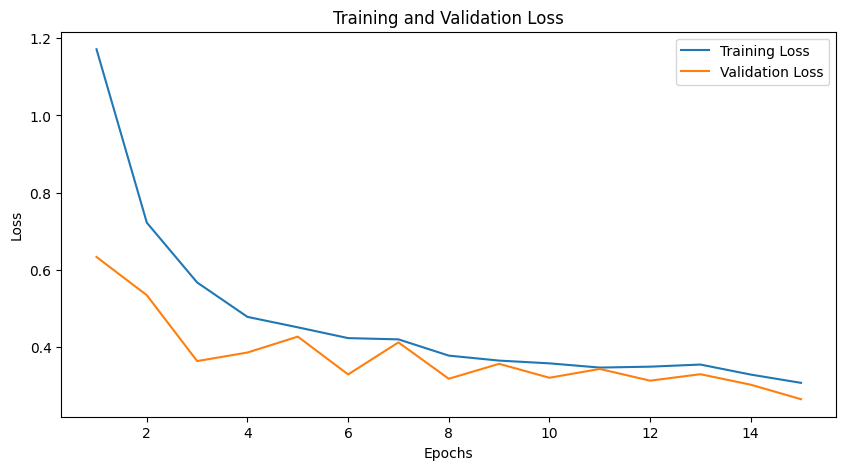

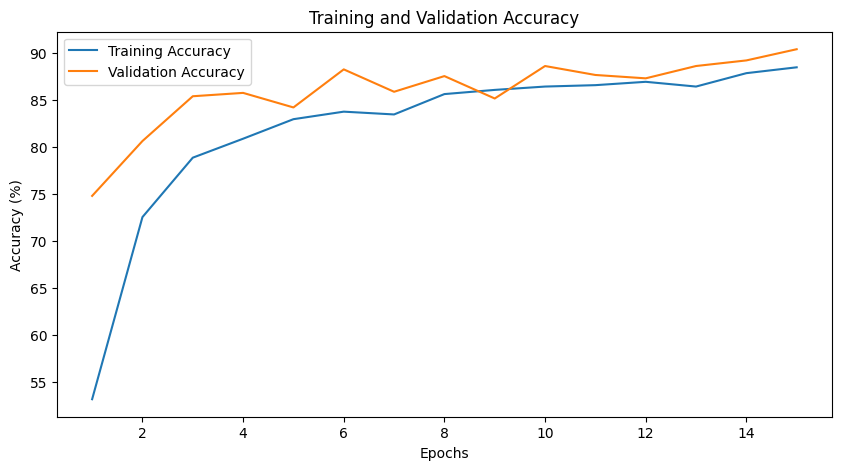

In [14]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [17]:
from torchvision.datasets import ImageFolder 
from sklearn.metrics import accuracy_score

# Test the models
test_data_dir = '/kaggle/input/multiclassification/test-20231109T183113Z-001/test'
test_dataset = ImageFolder(test_data_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

test_losses = []
test_accuracies = []
predictions = []
targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = torch.cat([vision_transformer(images), resnet101(images)], dim=1)
        loss = loss_fn(outputs, labels)

        test_losses.append(loss.item())

        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(targets, predictions)

# Print test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

# Metric evaluation table
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and targets to numpy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Classification Report
class_names = ['diabetic_retinopathy', 'normal', 'cataract', 'glaucoma']
print(classification_report(targets, predictions, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(targets, predictions)
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Print confusion matrix
print('\nConfusion Matrix:')
print(conf_df)

Test Accuracy: 0.9037
                      precision    recall  f1-score   support

diabetic_retinopathy       0.92      0.95      0.93       207
              normal       0.98      0.98      0.98       219
            cataract       0.88      0.80      0.84       201
            glaucoma       0.83      0.88      0.86       214

            accuracy                           0.90       841
           macro avg       0.90      0.90      0.90       841
        weighted avg       0.90      0.90      0.90       841


Confusion Matrix:
                      diabetic_retinopathy  normal  cataract  glaucoma
diabetic_retinopathy                   197       0         6         4
normal                                   1     214         1         3
cataract                                 9       1       160        31
glaucoma                                 8       3        14       189


In [20]:
ensemble_model_path = 'retinal.pth'
torch.save({
    'epoch': num_epochs,
    'vision_transformer_state_dict': vision_transformer.state_dict(),
    'resnet101_state_dict': resnet101.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, ensemble_model_path)

print(f'Ensemble model saved at: {ensemble_model_path}')


Ensemble model saved at: retinal.pth


In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class names and info
CLASS_NAMES = {
    0: 'Diabetic_Retinopathy',
    1: 'Normal',  
    2: 'Cataract',
    3: 'Glaucoma'
}

CLASS_INFO = {
    'Diabetic_Retinopathy': 'Include a variety of nutrient-rich foods: fruits, vegetables, whole grains, lean proteins, and healthy fats. Consume sources like fatty fish, flaxseeds, chia seeds, and walnuts for potential anti-inflammatory effects. Eat foods high in antioxidants, such as berries, citrus fruits, dark leafy greens, carrots, and nuts. Reduce saturated and trans fats found in fried and processed foods; opt for healthier fats like those in olive oil and nuts. Keep levels in check by limiting salt, choosing heart-healthy foods, and following medical advice.',
    'Normal': 'No visible retinal abnormalities. Stay Healthy !!! Stay Safe !!!',
    'Cataract': 'Eat foods high in antioxidants, including fruits, vegetables, and nuts. Include sources like fatty fish, flaxseeds, and walnuts. Ensure an adequate intake of vitamins A, C, and E, as well as zinc and selenium. Reduce intake of processed foods and excessive sugar. Consume lutein and zeaxanthin found in leafy greens and colorful vegetables.',
    'Glaucoma': 'Emphasize fruits, vegetables, whole grains, lean proteins, and healthy fats. Reduce caffeine intake; moderate sodium to manage intraocular pressure. Include sources like fatty fish, flaxseeds, and walnuts.'
}

# Load model   
checkpoint = torch.load('/kaggle/working/retinal.pth')
vision_transformer = timm.create_model('vit_base_patch16_224', num_classes=2)
vision_transformer.load_state_dict(checkpoint['vision_transformer_state_dict'])

resnet101 = timm.create_model('resnet101', num_classes=2)
filtered_state_dict = {k: v for k, v in checkpoint['resnet101_state_dict'].items() if k in resnet101.state_dict()}
resnet101.load_state_dict(filtered_state_dict, strict=False)

ensemble_model = VotingEnsemble([vision_transformer, resnet101])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble_model = ensemble_model.to(device)
ensemble_model.eval()

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Image
img_path = '/kaggle/input/image1/_15_7471583.jpg' 
img = Image.open(img_path).convert('RGB')
img = transform(img)

# Prediction
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    outputs = ensemble_model(img)
    _, predicted = outputs.max(1)
    
# Print results
print('Predicted class:', CLASS_NAMES[predicted.item()])
print('Class information:', CLASS_INFO[CLASS_NAMES[predicted.item()]]) 

Predicted class: Diabetic_Retinopathy
Class information: Include a variety of nutrient-rich foods: fruits, vegetables, whole grains, lean proteins, and healthy fats. Consume sources like fatty fish, flaxseeds, chia seeds, and walnuts for potential anti-inflammatory effects. Eat foods high in antioxidants, such as berries, citrus fruits, dark leafy greens, carrots, and nuts. Reduce saturated and trans fats found in fried and processed foods; opt for healthier fats like those in olive oil and nuts. Keep levels in check by limiting salt, choosing heart-healthy foods, and following medical advice.
